# Self-Driving Car Engineer Nanodegree

## Project #2: **Advanced Lane Finding**


### Notebook Configuration

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import pathlib as pl
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Camera Calibration

In [3]:
chessboard_nx = 9
chessboard_ny = 6
camera_calibration = {}

def calibrate_camera(shape):

    global camera_calibration
    if shape in camera_calibration:
        return camera_calibration[shape];

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_ny*chessboard_nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_nx,0:chessboard_ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    calibration_dir = "camera_cal"

    # plt.figure()
    # fig, axs = plt.subplots(2, 3, figsize=(10,5), tight_layout=True)
    # ax_iter = iter(axs.flatten())

    # Step through the list and search for chessboard corners
    for file in sorted(pl.Path(calibration_dir).glob("cal*.jpg")):
        img = cv2.imread(str(file))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_nx,chessboard_ny),None)

        if ret == False:
            continue

        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #
        # ax = next(ax_iter, None)
        # if ax != None:
        #     ax.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)

    camera_calibration[shape] = (mtx, dist)
    return camera_calibration[shape]


def undistort_image(img):
    cal = calibrate_camera(img.shape[1::-1]);
    return cv2.undistort(img, cal[0], cal[1], None, cal[0])

## Verify Camera Calibration

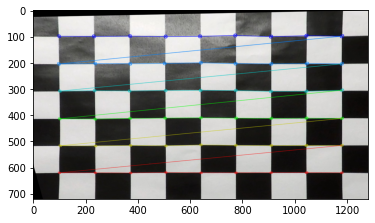

In [4]:
def undistort_warp_chessboard(img):
    w, h = img.shape[1::-1]

    img_undist = undistort_image(img)

    ret, corners = cv2.findChessboardCorners(img_undist, (chessboard_nx,chessboard_ny), None)
    if ret:
        cv2.drawChessboardCorners(img_undist, (chessboard_nx,chessboard_ny), corners, True)
        src = np.array([corners[0], corners[chessboard_nx-1], corners[-1], corners[-chessboard_nx]], dtype=np.float32);
        dst = np.array([[100,100], [w-100,100], [w-100,h-100], [100,h-100]], dtype=np.float32);
        M = cv2.getPerspectiveTransform(src, dst)
        img_undist = cv2.warpPerspective(img_undist, M, (w, h), flags=cv2.INTER_CUBIC)

    return img_undist


# test camera calibration
img = cv2.imread('camera_cal/calibration3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = undistort_warp_chessboard(img)
plt.figure()
plt.imshow(img)


## Gradient and Color Thresholds

In [5]:
def thresholds(img, s_thresh=(170, 255), h_thresh=(20, 25),
               ksize=5, sx_thresh=(20, 100), mag_thresh=(0, 255), dir_thresh=((0, np.pi/2))):
    #img = np.copy(img)

    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)

    # threshold gradient magnitude
    mag_binary = np.zeros_like(scaled_sobelxy)
    mag_binary [(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1

    # threshold direction
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary [(dir_sobel >= dir_thresh[0]) & (dir_sobel <= dir_thresh[1])] = 1

    # threshold x gradient
    sobelx_binary = np.zeros_like(scaled_sobelx)
    sobelx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(s_binary == 1) | (sobelx_binary == 1) | (h_binary == 1)] = 1
    return combined_binary

    #color_binary = np.dstack((sxbinary, h_binary, s_binary)) * 255
    #return color_binary


## Perspective Transform

In [6]:
# define a trapezoid a source for the perspective transform
def warp_src(img_size):
    return np.float32([
        [img_size[0] / 2 - 57, img_size[1] / 2 + 100],
        [img_size[0] / 6 - 7, img_size[1]],
        [img_size[0] * 5 / 6 + 40, img_size[1]],
        [img_size[0] / 2 + 57, img_size[1] / 2 + 100]
    ])

# destination geometry is a rectangle
def warp_dst(img_size):
    return np.float32([
        [(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]
    ])


perspective_matrix = {}

def warp_image(img, inverse=False):

    img_size = img.shape[1::-1]

    src = warp_src(img_size)
    dst = warp_dst(img_size)

    # Compute and cache matrices for perspective transformation in both directions
    global perspective_matrix
    if img_size not in perspective_matrix:
        perspective_matrix[img_size] = (
            cv2.getPerspectiveTransform(src, dst),
            cv2.getPerspectiveTransform(dst, src)
        )
    
    # Apply perspective transform
    return cv2.warpPerspective(img, perspective_matrix[img_size][int(inverse)], img_size, flags=cv2.INTER_LINEAR)


## Helper Functions

In [7]:
def fy(y, fit):
    return fit[2] + fit[1] * y + fit[0] * y**2


def plot_fits(img, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
#     try:
    left_fitx = fy(ploty, left_fit)
    right_fitx = fy(ploty, right_fit)
#     except TypeError:
#         # Avoids an error if `left` and `right_fit` are still none or incorrect
#         print('The function failed to fit a line!')
#         left_fitx = fy(ploty, [1,1,0])
#         right_fitx = fy(ploty, [1,1,0])

    # Plot the polynomial lines onto the image
    
    draw_left_pts = (np.asarray([left_fitx, ploty]).T).astype(np.int32)
    cv2.polylines(img, [draw_left_pts], False, (255,255,0), 3)
    
    draw_right_pts = (np.asarray([right_fitx, ploty]).T).astype(np.int32)
    cv2.polylines(img, [draw_right_pts], False, (255,255,0), 3)

    return img


def fit_poly(leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def fit_lanes_by_windows(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    img_out = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    img_rectangles = np.zeros_like(img_out)
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # ind the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(img_rectangles,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(img_rectangles,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((win_xleft_low <= nonzerox) & (nonzerox < win_xleft_high) & (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((win_xright_low <= nonzerox) & (nonzerox < win_xright_high) & (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
#     try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
#     except ValueError:
#         # Avoids an error if the above is not implemented fully
#         pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Draw windows and selected pixels onto visualization image
    img_out[lefty, leftx] = [255, 0, 0]
    img_out[righty, rightx] = [0, 0, 255]
    img_out = cv2.addWeighted(img_out, 1.0, img_rectangles, 0.7, 1)
        
    # Now fit the polynomial
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
    
    plot_fits(img_out, left_fit, right_fit)
    
    return left_fit, right_fit, img_out



def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((fy(nonzeroy, left_fit)-margin <= nonzerox) & (nonzerox < fy(nonzeroy, left_fit)+margin)).nonzero()[0]
    right_lane_inds = ((fy(nonzeroy, right_fit)-margin <= nonzerox) & (nonzerox < fy(nonzeroy, right_fit)+margin)).nonzero()[0]

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit_upd, right_fit_upd = fit_poly(leftx, lefty, rightx, righty)
              
    
    ## Visualization ##
        
    # Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = fy(ploty, left_fit)
    right_fitx = fy(ploty, right_fit)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Draw the fitted polynomials onto the image
    plot_fits(out_img, left_fit_upd, right_fit_upd)
    

    ## End visualization steps ##

    return left_fit_upd, right_fit_upd, out_img


def draw_lane_unwarped(img, left_fit, right_fit):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = fy(ploty, left_fit)
    right_fitx = fy(ploty, right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros(img.shape[0:2], np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp_image(color_warp, True) 
    # Combine the result with the original image
    img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return img


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None



## Build a Lane Finding Pipeline

In [8]:
def pipeline(img, visualize=False):
    """
    Process a single image through the complete pipeline.
    """

    if visualize:
        plt.figure()
        plt.imshow(img)
    
    # undistort the image using camera calibration
    img_undist = undistort_image(img)

    if visualize:
        pts = np.rint(warp_src(img.shape[1::-1])).astype(np.int32)
        pts = pts.reshape(-1,1,2)
        img_marker = img_undist.copy()
        cv2.polylines(img_marker, [pts], True, (255,0,0), 2)

        plt.figure()
        plt.imshow(img_marker)

    # apply gradient and color thresholds
    img_thresh = thresholds(img_undist)

    if visualize:
        plt.figure()
        plt.imshow(img_thresh, cmap='gray')

    # apply perspective transform
    img_warped = warp_image(img_thresh)
    
    if visualize:
        plt.figure()
        plt.imshow(img_warped, cmap='gray')
    
    left_fit, right_fit, img_fit = fit_lanes_by_windows(img_warped)    

    if visualize:
        plt.figure()
        plt.imshow(img_fit)
    
    img_result = draw_lane_unwarped(img_undist, left_fit, right_fit)
    
    if visualize:
        plt.figure()
        plt.imshow(img_result)
    
    return img_result

## Execute on Images
Executing the pipeline on all images in 'test_images'.

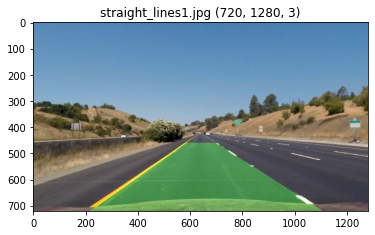

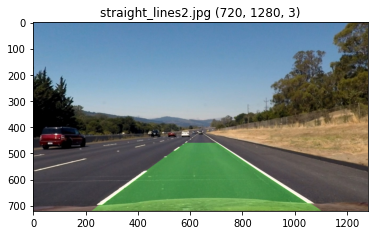

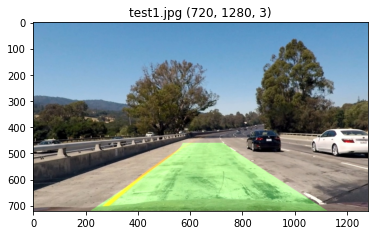

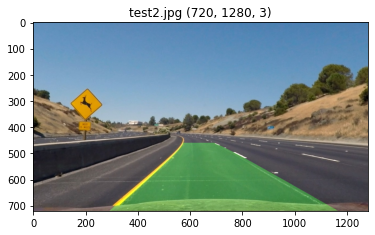

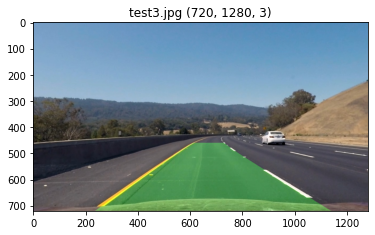

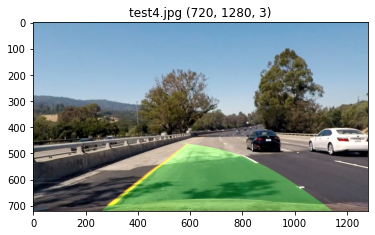

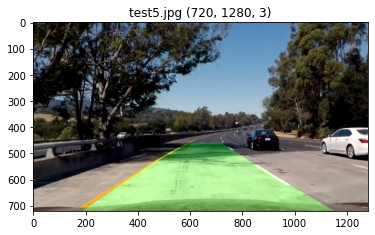

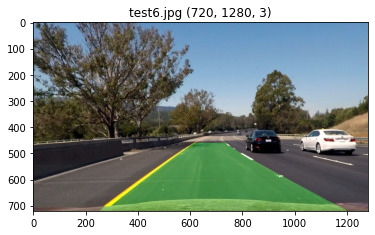

In [9]:
# apply the processing pipe line to all images in the input directory

input_dir = 'test_images'
output_dir = 'output_images'

for file in sorted(pl.Path(input_dir).iterdir()):

    # read and process
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pipeline(img)
    
    # plot in notebook
    plt.figure()
    plt.title("{} {}".format(file.name, img.shape))
    plt.imshow(img)
    
    # write to file
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_dir + '/' + file.name, img)

## Execute on Videos
Executing the pipeline on all videos in 'test_videos', including **the challenge**!

In [10]:
# apply the processing pipe line to all videos in the input directory

input_dir = 'input_videos'
output_dir = 'output_videos'

for file in sorted(pl.Path(input_dir).iterdir()):
    
    print('Parsing video "', file, '" with dimensions ', sep='')
    #clip = VideoFileClip(str(file))
    clip = VideoFileClip(str(file)).subclip(0,5)
    
    file_output = output_dir + '/' + file.name
    clip_output = clip.fl_image(pipeline)
    
    %time clip_output.write_videofile(file_output, audio=False)    

    display(HTML("""
<div>{1}</div>
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_output, file_output)))
    print()

Parsing video "input_videos/challenge_video.mp4" with dimensions 


t:   1%|▏         | 2/150 [00:00<00:08, 17.03it/s, now=None]

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
CPU times: user 26.1 s, sys: 4.04 s, total: 30.1 s
Wall time: 16.7 s



Parsing video "input_videos/harder_challenge_video.mp4" with dimensions 


t:   2%|▏         | 2/125 [00:00<00:08, 15.04it/s, now=None]

Moviepy - Building video output_videos/harder_challenge_video.mp4.
Moviepy - Writing video output_videos/harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/harder_challenge_video.mp4
CPU times: user 27.4 s, sys: 3.48 s, total: 30.8 s
Wall time: 19 s



Parsing video "input_videos/project_video.mp4" with dimensions 


t:   2%|▏         | 2/125 [00:00<00:07, 17.26it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 23.9 s, sys: 3.64 s, total: 27.5 s
Wall time: 15.9 s


We are done!